In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 50.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s

In [2]:
# Data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Darts time series library
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.utils.timeseries_generation import linear_timeseries
from darts.utils.likelihood_models import GaussianLikelihood

# Scikit-learn for metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

In [3]:
# Load the prepared daily dataset
DATA_PATH = "/kaggle/input/freshretailnet-50k-daily-imputed/daily_df_imputed.parquet"
df = pd.read_parquet(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (4500000, 17)


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,daily_sale_imputed,oos_hours_total,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,0,0,5,6,65,38,2024-03-28,0.100000,0,1.0,0,0,1.6999,15.48,73.54,1.97
1,0,0,0,5,6,65,38,2024-03-29,0.114286,3,1.0,0,0,3.0190,15.08,76.56,1.71
2,0,0,0,5,6,65,38,2024-03-30,0.000000,6,1.0,1,0,2.0942,15.91,76.47,1.73
3,0,0,0,5,6,65,38,2024-03-31,0.218182,13,1.0,1,0,1.5618,16.13,77.40,1.76
4,0,0,0,5,6,65,38,2024-04-01,0.533333,15,1.0,0,0,3.5386,15.37,78.26,1.25


In [4]:
# Select category IDs to model
category_ids = [81, 65, 17]

# Build a dict of Darts TimeSeries for each category
series_dict = {}
for cat in category_ids:
    df_cat = (
        df[df['third_category_id']==cat]
          .groupby('dt', as_index=False)['daily_sale_imputed']
          .sum()
          .sort_values('dt')
    )
    # Convert to Darts TimeSeries, fill missing dates
    ts = TimeSeries.from_dataframe(
        df_cat,
        time_col='dt',
        value_cols='daily_sale_imputed',
        fill_missing_dates=True,
        freq='D'
    )
    series_dict[cat] = ts
    print(f"Category {cat}: series length = {len(ts)}")

Category 81: series length = 90
Category 65: series length = 90
Category 17: series length = 90


In [5]:
# 80/20 split for each series
train_series = {}
val_series = {}
for cat, ts in series_dict.items():
    cutoff = int(len(ts)*0.8)
    train_series[cat], val_series[cat] = ts[:cutoff], ts[cutoff:]
    print(f"Cat {cat}: train={len(train_series[cat])}, val={len(val_series[cat])}")

Cat 81: train=72, val=18
Cat 65: train=72, val=18
Cat 17: train=72, val=18


In [6]:
models = {}
for cat in category_ids:
    print(f"Training N-BEATS for category {cat}...")
    model = NBEATSModel(
    input_chunk_length=28,     # look back 28 days
    output_chunk_length=7,     # forecast 7 days ahead
    n_epochs=50,               # number of training epochs
    dropout=0.1,               # dropout in each layer
    batch_size=8,             # minibatch size
    random_state=42,           # reproducibility
    add_encoders={
        # cyclical encoding for day-of-week
        "cyclic": {
            "past":   ["dayofweek"],
            "future": ["dayofweek"],
        },
        # numeric month-of-year encoding
        "datetime_attribute": {
            "past":   ["month"],
            "future": ["month"],
        }
    },
    pl_trainer_kwargs={        # pass through to PyTorch Lightning
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "devices": 1,
    }
)
    model.fit(
        series=train_series[cat],
        past_covariates=None,
        future_covariates=None,
        verbose=True
    )
    models[cat] = model

Training N-BEATS for category 81...


Training: |          | 0/? [00:00<?, ?it/s]

Training N-BEATS for category 65...


Training: |          | 0/? [00:00<?, ?it/s]

Training N-BEATS for category 17...


Training: |          | 0/? [00:00<?, ?it/s]

In [7]:
forecasts = {}
metrics = {}
for cat in category_ids:
    model = models[cat]
    val_ts = val_series[cat]
    # Make a forecast of same length as validation
    pred = model.predict(len(val_ts))
    forecasts[cat] = pred
    # Calculate metrics
    mae = mean_absolute_error(val_ts.values(), pred.values())
    rmse = np.sqrt(mean_squared_error(val_ts.values(), pred.values()))
    metrics[cat] = {'MAE': mae, 'RMSE': rmse}
    print(f"Category {cat} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Predicting: |          | 0/? [00:00<?, ?it/s]

Category 81 → MAE: 1741.01, RMSE: 2085.03


Predicting: |          | 0/? [00:00<?, ?it/s]

Category 65 → MAE: 849.55, RMSE: 948.28


Predicting: |          | 0/? [00:00<?, ?it/s]

Category 17 → MAE: 76.08, RMSE: 98.72


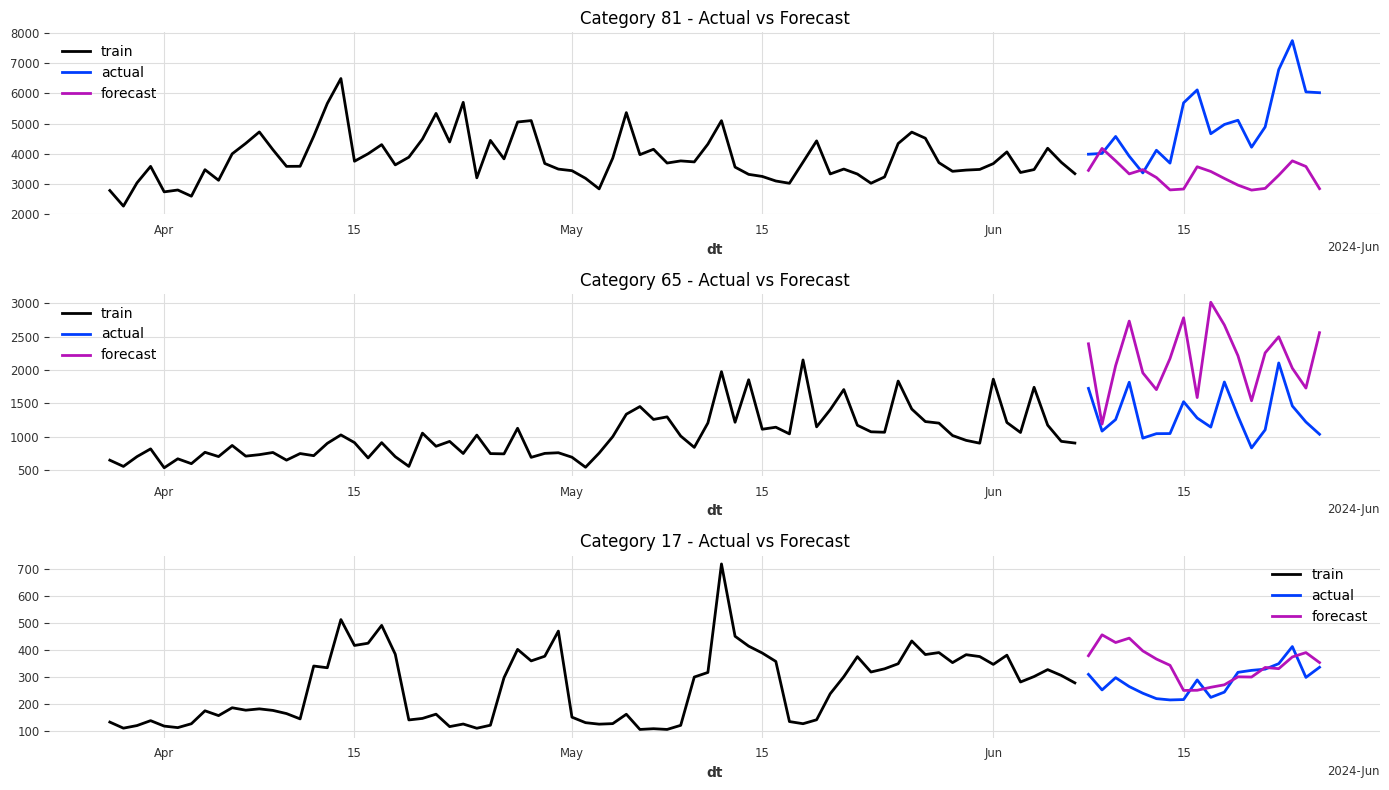

In [8]:
plt.figure(figsize=(14, 8))
for i, cat in enumerate(category_ids, 1):
    plt.subplot(len(category_ids), 1, i)
    train_series[cat].plot(label='train')
    val_series[cat].plot(label='actual')
    forecasts[cat].plot(label='forecast')
    plt.title(f"Category {cat} - Actual vs Forecast")
    if i == 1:
        plt.legend()
plt.tight_layout()
plt.show()